# Weather in BERLIN TEMPELHOF

In [48]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm


from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# miscellaneous
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore')

mpl.rc('figure',figsize=(12,3),dpi=200)

## Load Data

Data contains the daily temp. from Berlin Tempelhof from 1876-2022

<AxesSubplot:xlabel='date'>

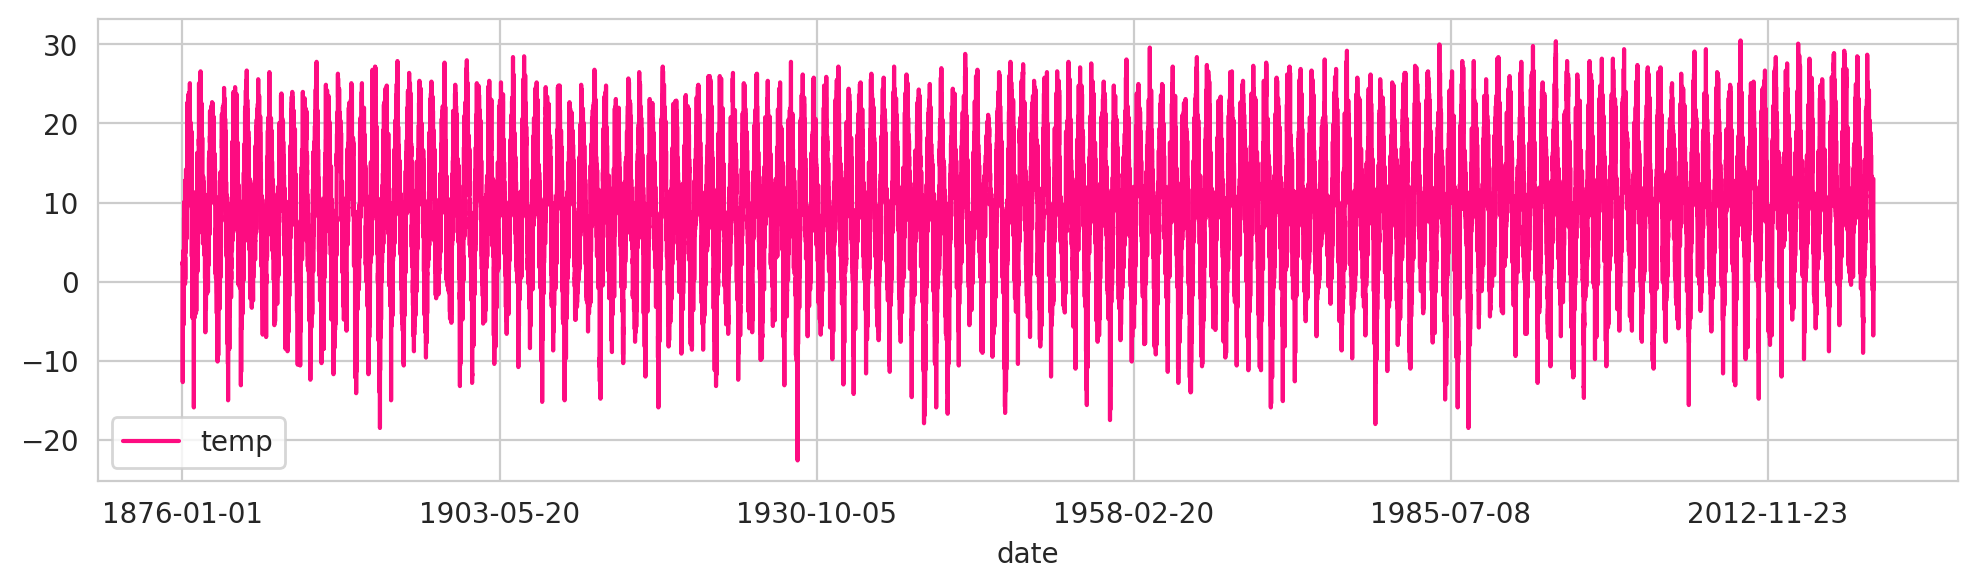

In [49]:
df_raw = pd.read_csv('data/train.csv', sep=',',parse_dates=True)
weather = df_raw.set_index('date')
weather.plot(c='#FD0C81')

## Time Series Decomposion

<AxesSubplot:xlabel='date'>

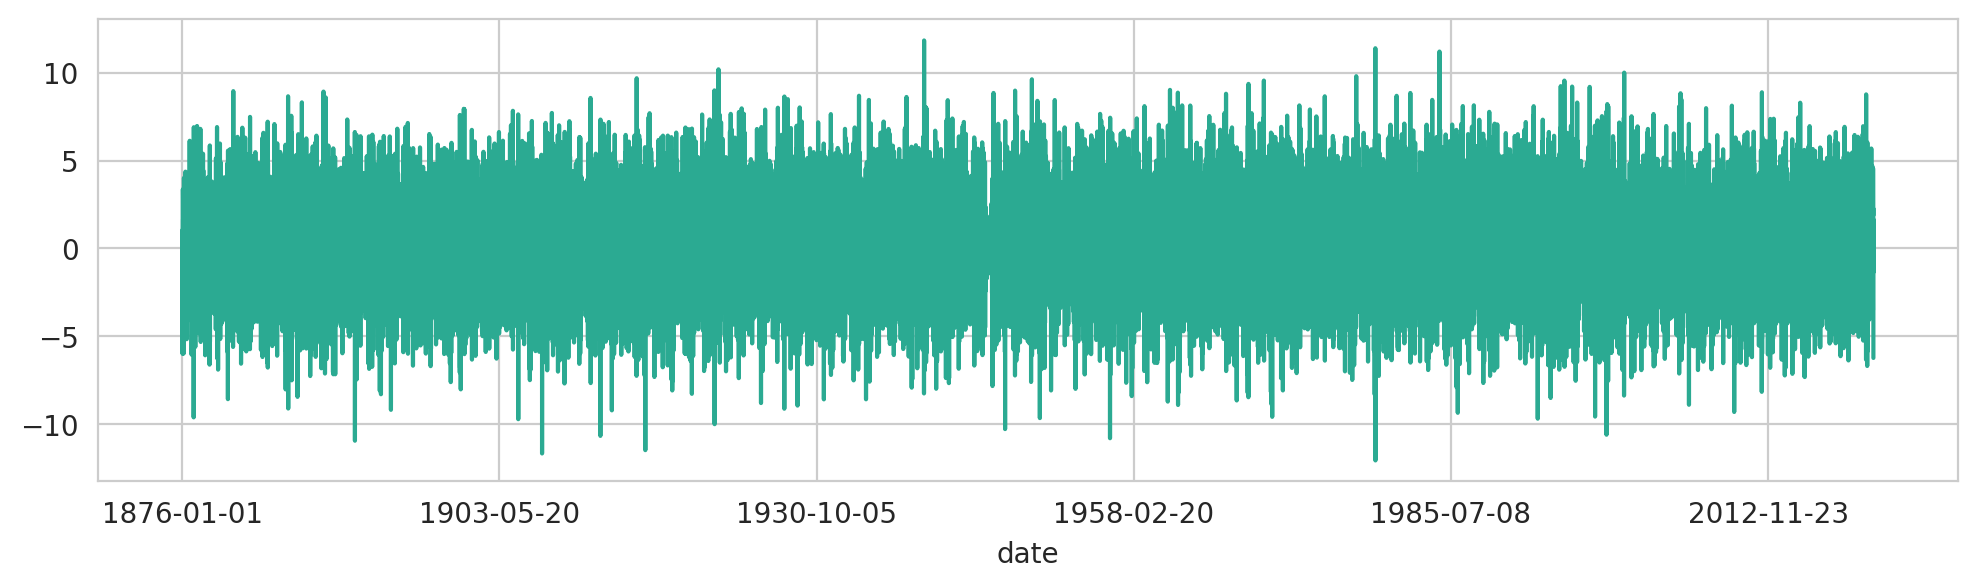

In [50]:
add_result = seasonal_decompose(weather, model='additive',period=12)
basic_model = add_result.trend + add_result.seasonal
residual = add_result.resid
residual.plot(c='#2BAA92')


In [51]:
df_res = residual.dropna()

## Detrend via polynomial Regression

In [52]:
weather['timestep'] = list(range(weather.shape[0]))

In [53]:
X = weather[['timestep']]
y = weather['temp']

In [54]:
trend_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

In [55]:

trend_model.fit(X,y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [84]:
X

,timestep
date,
1876-01-01,0
1876-01-02,1
1876-01-03,2
1876-01-04,3
1876-01-05,4
...,...
2021-12-27,53321
2021-12-28,53322
2021-12-29,53323


In [56]:
weather['trend'] = trend_model.predict(X)

In [57]:
weather['detrended'] = weather['temp'] - weather['trend']

<AxesSubplot:xlabel='date'>

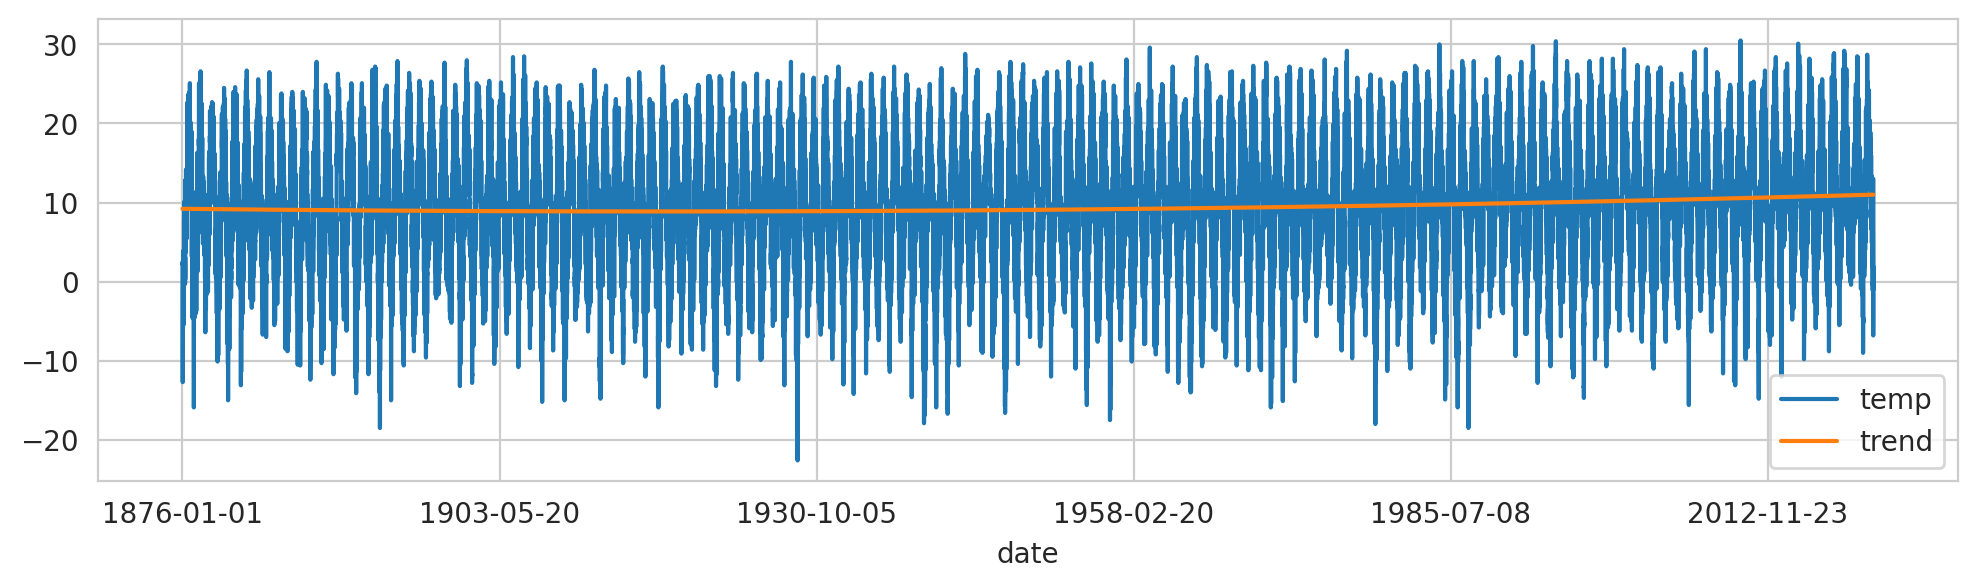

In [58]:
weather[['temp', 'trend']].plot()

## Remove Seasonsality

In [59]:
weather.index = pd.to_datetime(weather.index)

In [60]:
weather['day'] = weather.index.dayofyear

In [61]:
weather['day'].value_counts()

1      146
252    146
250    146
249    146
248    146
      ... 
121    146
120    146
119    146
118    146
366     36
Name: day, Length: 366, dtype: int64

In [62]:
# feature and target for seasonality model

X_season = weather[['day']]
y_season = weather['detrended']

In [63]:
# seasonality model

seasonal_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

In [64]:
seasonal_model.fit(X_season, y_season)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [65]:
weather['season'] = seasonal_model.predict(X_season)

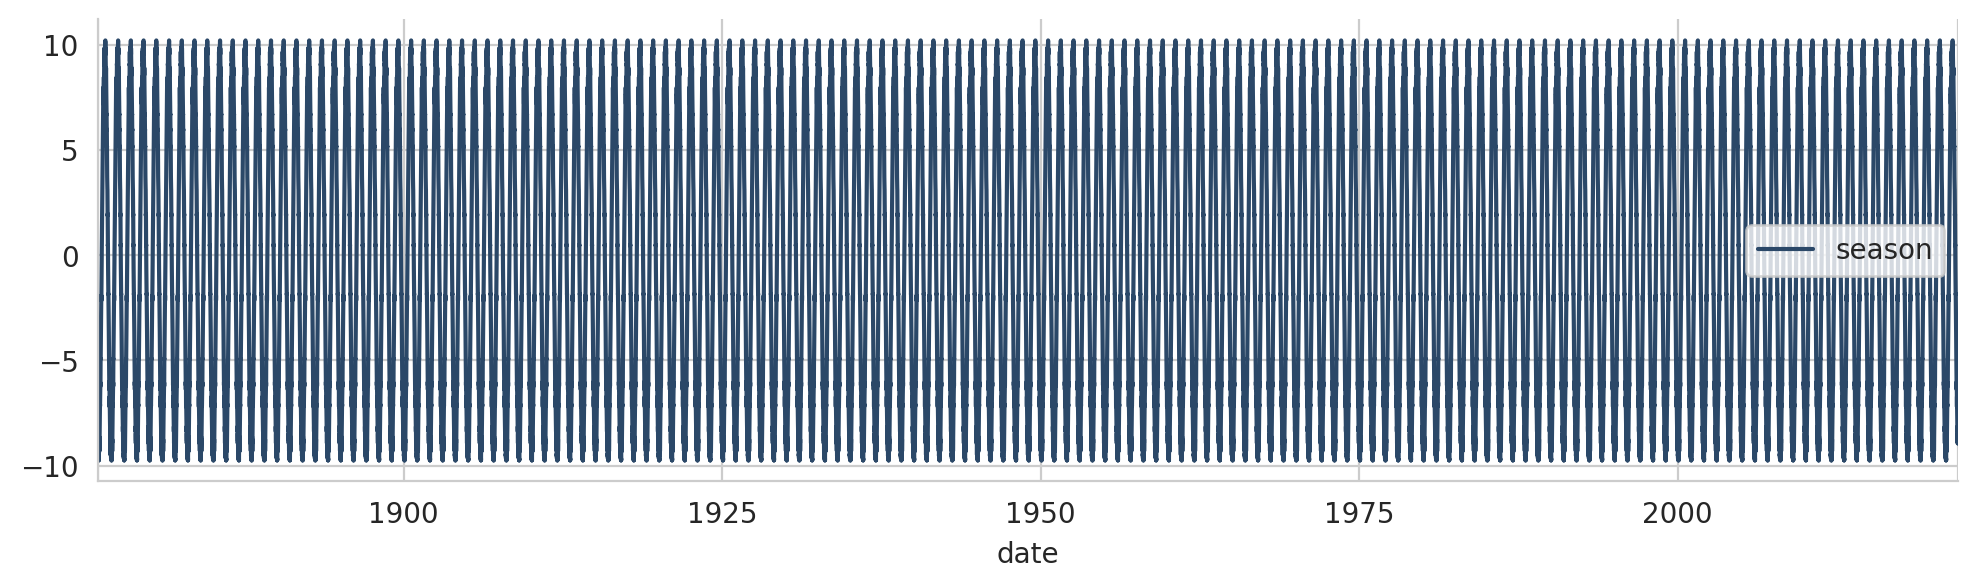

In [128]:
weather[['season']].plot(legend=True, c='#2b4868')
sns.despine()

## Get Basic Model

In [ ]:
weather['trend_seasonal'] = weather['trend'] + weather['season']



## Get Reminder

In [67]:
# leftover time series devoid of trend and seasonality

weather['remainder'] = weather['temp'] - weather['trend_seasonal']

<AxesSubplot:xlabel='date'>

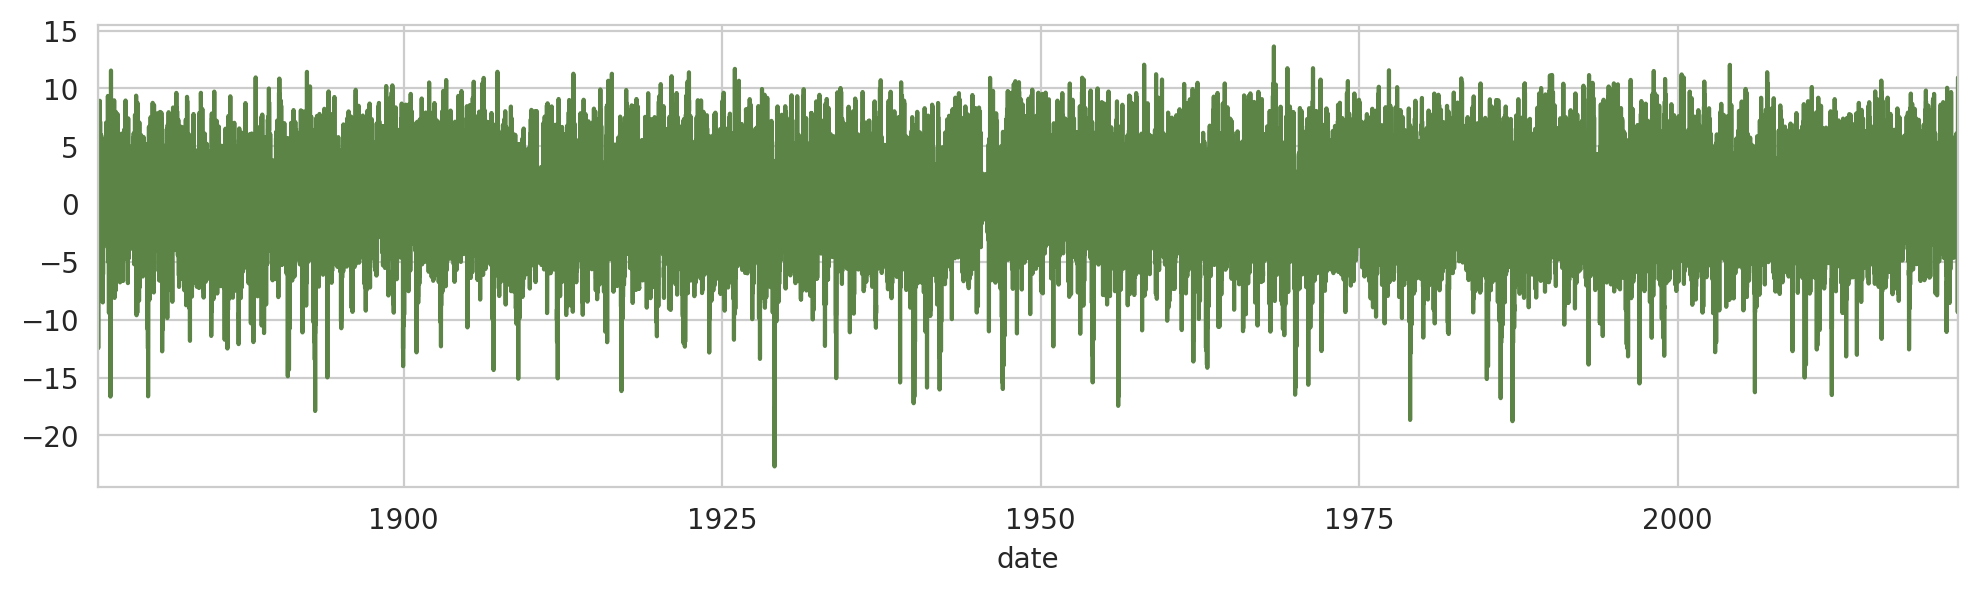

In [129]:
weather['remainder'].plot(c='#5c8447')

## Check Stationarity of Time Series

In [70]:
def p_values(series):
    """
    returns p-values for ADF and KPSS Tests on a time series
    """
    # p value from Augmented Dickey-Fuller (ADF) Test
    p_adf = adfuller(series, autolag="AIC")[1]
    
    # p value from Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test
    p_kpss = kpss(series, regression="c", nlags="auto")[1]
    
    return round(p_adf,6), round(p_kpss,6)


def test_stationarity(series):
    """
    returns likely conclusions about series stationarity
    """
    # test heteroscedasticity with qcd
    qcd = qcd_variance(series)
    
    if qcd >= 0.50:
        print(f"\n non-stationary: heteroscedastic (qcd = {qcd}) \n")
    
    # test stationarity
    else:
        p_adf, p_kpss = p_values(series)
        
        # print p-values
        print( f"\n p_adf: {p_adf}, p_kpss: {p_kpss}" )
    
        if (p_adf < 0.01) and (p_kpss >= 0.05):
            print('\n stationary or seasonal-stationary')
            
        elif (p_adf >= 0.1) and (p_kpss < 0.05):
            print('\n difference-stationary')
            
        elif (p_adf < 0.1) and (p_kpss < 0.05):
            print('\n trend-stationary')
        
        else:
            print('\n non-stationary; no robust conclusions\n')

def qcd_variance(series,window=10):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    
    # quartile coefficient of dispersion 
    qcd = (Q3-Q1)/(Q3+Q1)
    
    return round(qcd,6)

In [71]:
test_stationarity(weather['remainder'])


 p_adf: 0.0, p_kpss: 0.1

 stationary or seasonal-stationary


## Check for Autocorrelation and Autocorrelation

In [73]:
def auto_correlation_plot(series):
    """
    plots autocorrelations for a given series
    """

    plot_acf(series,zero=False,lags=25)
    plt.xlabel('number of lags')
    plt.ylabel('autocorrelation')
    
def partial_auto_correlation_plot(series):
    """
    plots partial autocorrelations for a given series
    """
    plot_pacf(series,zero=False,lags=25)
    plt.xlabel('number of lags')
    plt.ylabel('partial autocorrelation')

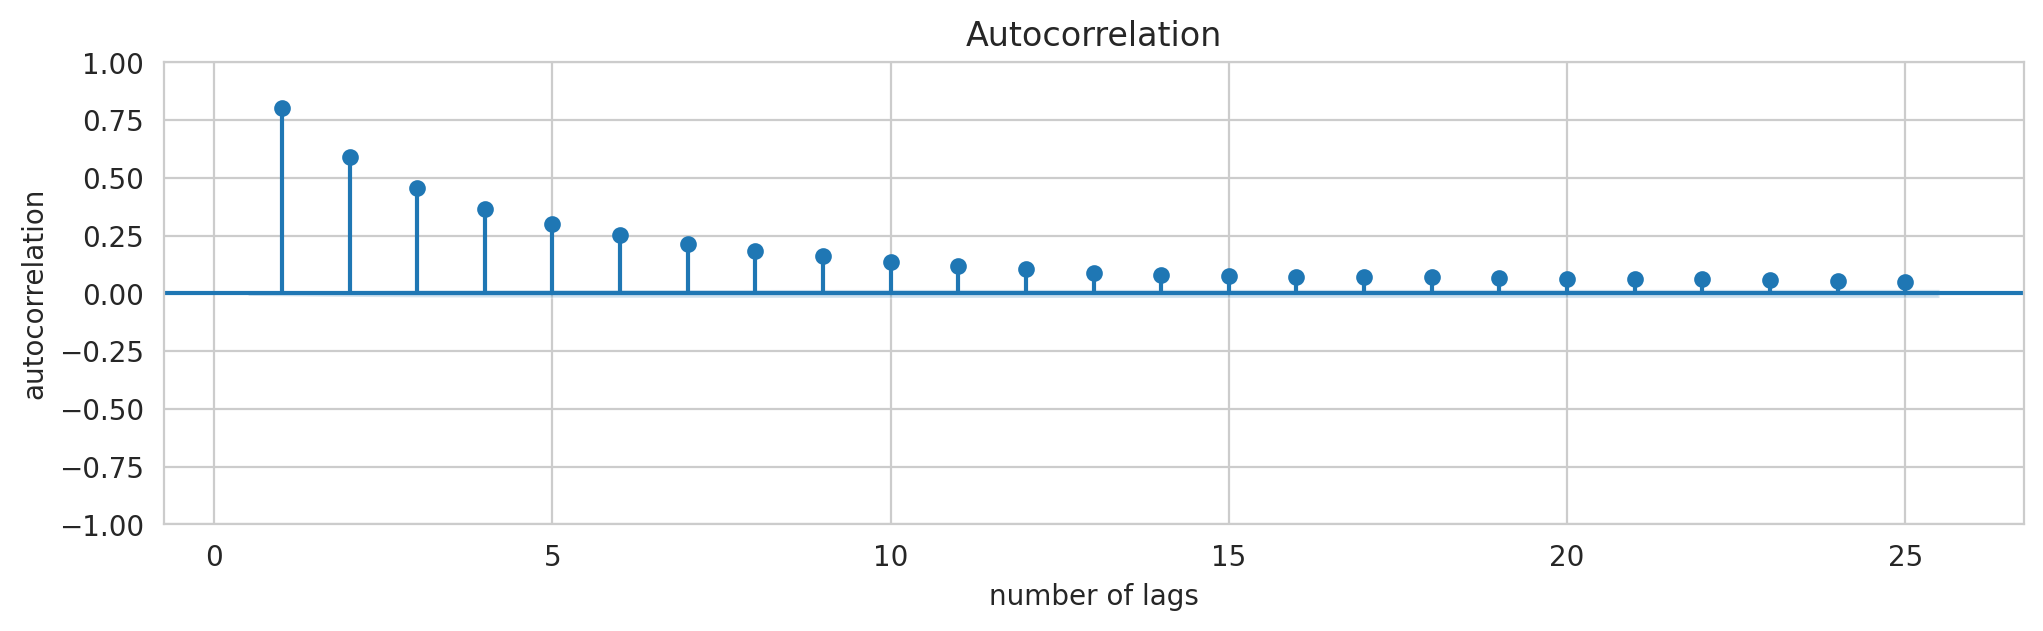

In [74]:
auto_correlation_plot(weather['remainder'])

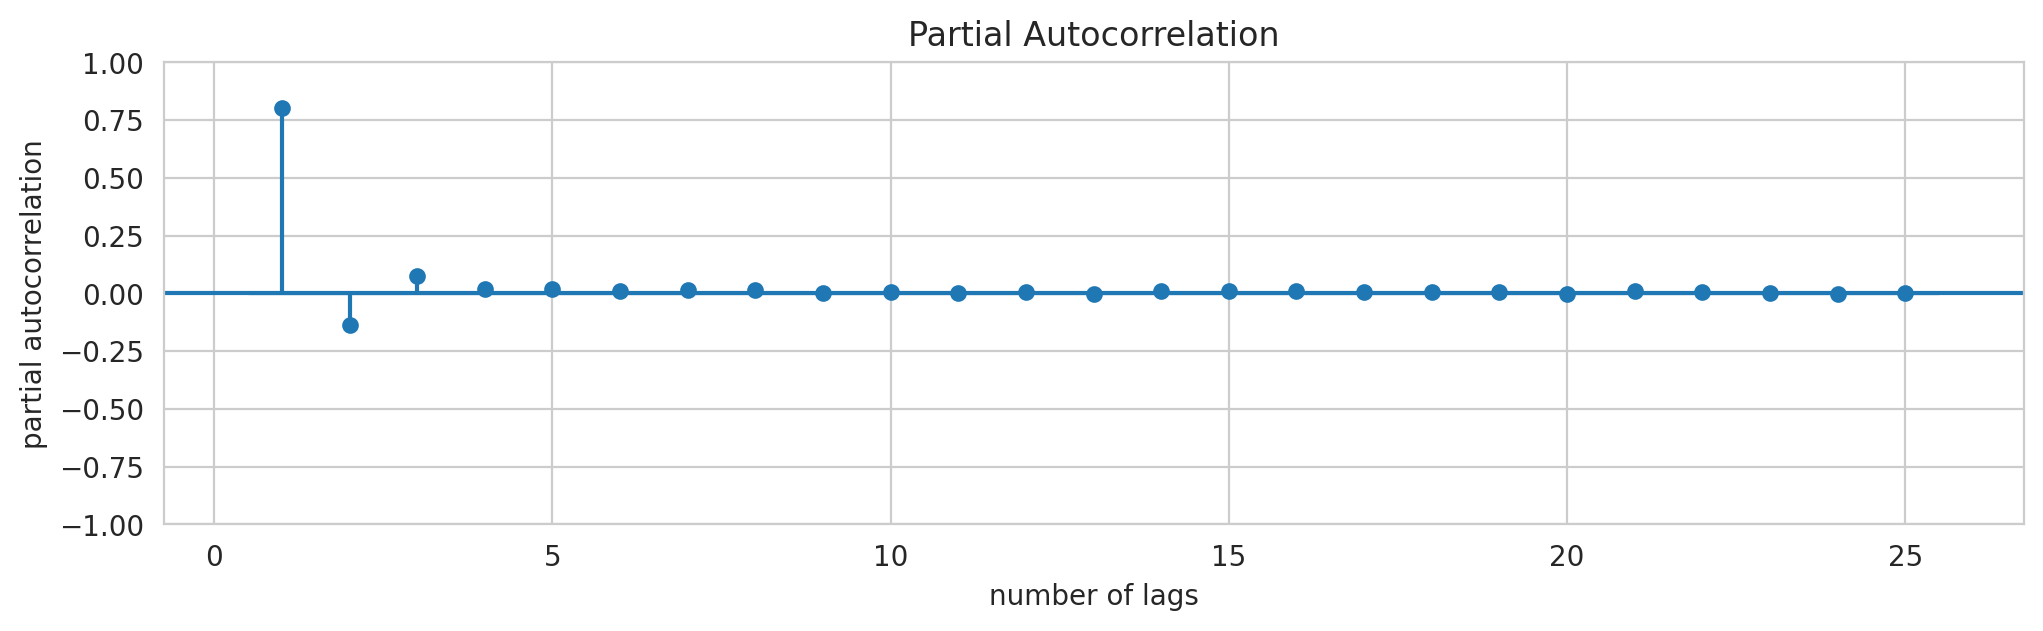

In [75]:
partial_auto_correlation_plot(weather['remainder'])

## Select Model

In [76]:
model = pm.auto_arima(
    weather['remainder'], 
    start_p=0,
    max_p=4,
    seasonality = True,
    stationarity = True,
    trace = True,
    n_jobs=5
)

Performing stepwise search to minimize aic
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=244567.490, Time=5.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=292631.966, Time=0.61 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=237827.858, Time=1.62 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=256164.698, Time=4.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=292629.966, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=236798.795, Time=1.97 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=236482.258, Time=3.20 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=236466.601, Time=3.09 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=236394.007, Time=47.94 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=236445.875, Time=20.26 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=236433.085, Time=50.75 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=236410.064, Time=31.10 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=236391.673, Time=17.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=236443.875, Time=7.46 sec


In [77]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                53326
Model:               SARIMAX(4, 0, 1)   Log Likelihood             -118189.837
Date:                Fri, 03 Feb 2023   AIC                         236391.673
Time:                        13:35:51   BIC                         236444.979
Sample:                    01-01-1876   HQIC                        236408.321
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8752      0.010    187.465      0.000       1.856       1.895
ar.L2         -1.0860      0.012    -89.928      0.000      -1.110      -1.062
ar.L3          0.2647      0.009     29.204      0.000       0.247       0.282
ar.L4         -0.0611      0.005    -13.561      0.000      -0.070      -0.052
ma.L1         -0.9549      0.009   -105.807      0.000      -0.973      -0.937
sigma2         4.9274      0.026    187.194      0.000       4.876       4.979
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1294.54
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.10
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Build Model

In [78]:
params = (4,0,1)
params_s = (0,0,0,0)


mod = SARIMAX(weather['remainder'],
        order=params,
        seasonal_order=params_s,
        enforce_stationarity=False,
        enforce_invertibility=False)

model_stats = mod.fit()
model_stats.summary().tables[1]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21728D+00    |proj g|=  1.83630D-02

At iterate    5    f=  2.21700D+00    |proj g|=  3.86132D-04

At iterate   10    f=  2.21700D+00    |proj g|=  9.21634D-04

At iterate   15    f=  2.21682D+00    |proj g|=  1.60062D-02

At iterate   20    f=  2.21637D+00    |proj g|=  3.19819D-02

At iterate   25    f=  2.21629D+00    |proj g|=  1.15475D-02

At iterate   30    f=  2.21624D+00    |proj g|=  4.41060D-02

At iterate   35    f=  2.21621D+00    |proj g|=  1.18074D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     94      2     0     0   4.373D-04   2.216D+00
  F =   2.2162086420152405     

ABNORMAL_TERMINATION_IN_LNSRCH                              


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,1.8574,0.013,141.996,0.000,1.832,1.883
ar.L2,-1.0692,0.014,-74.300,0.000,-1.097,-1.041
ar.L3,0.2591,0.009,27.774,0.000,0.241,0.277
ar.L4,-0.0577,0.005,-12.262,0.000,-0.067,-0.048
ma.L1,-0.9372,0.012,-75.975,0.000,-0.961,-0.913
sigma2,4.9273,0.026,187.127,0.000,4.876,4.979


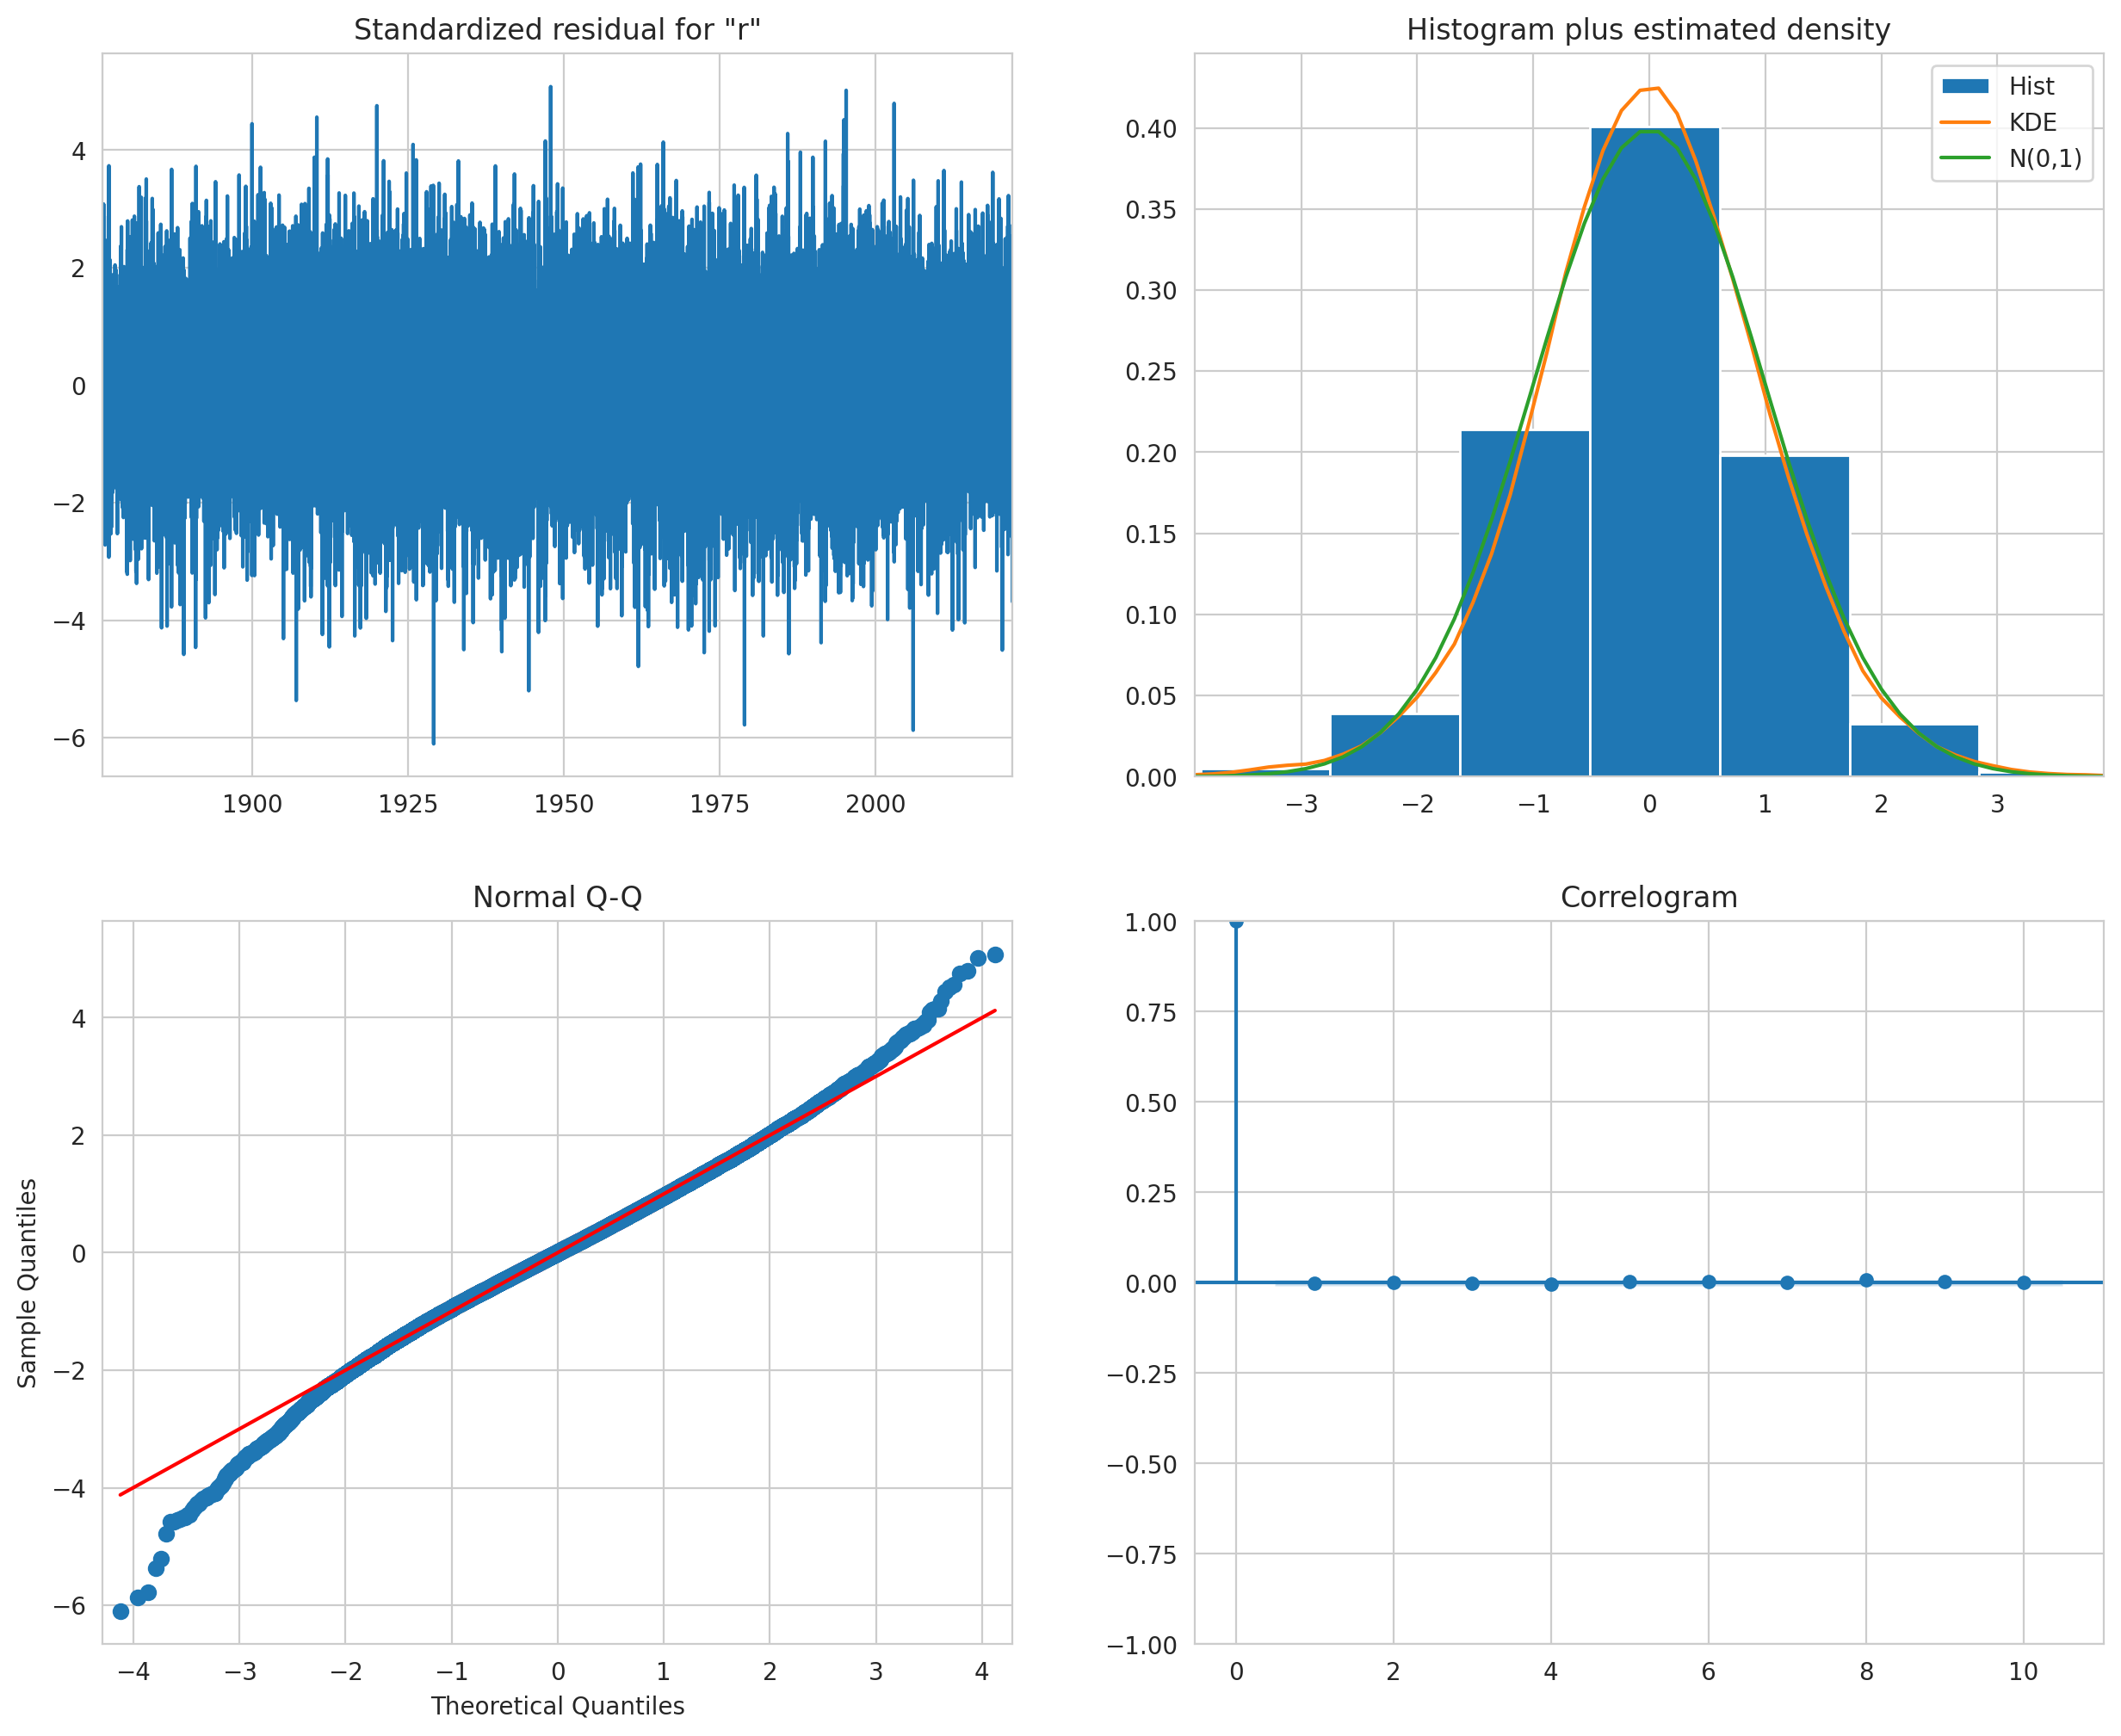

In [79]:
model_stats.plot_diagnostics(figsize=(15, 12))
plt.show()

## Make Predictions for Training Data

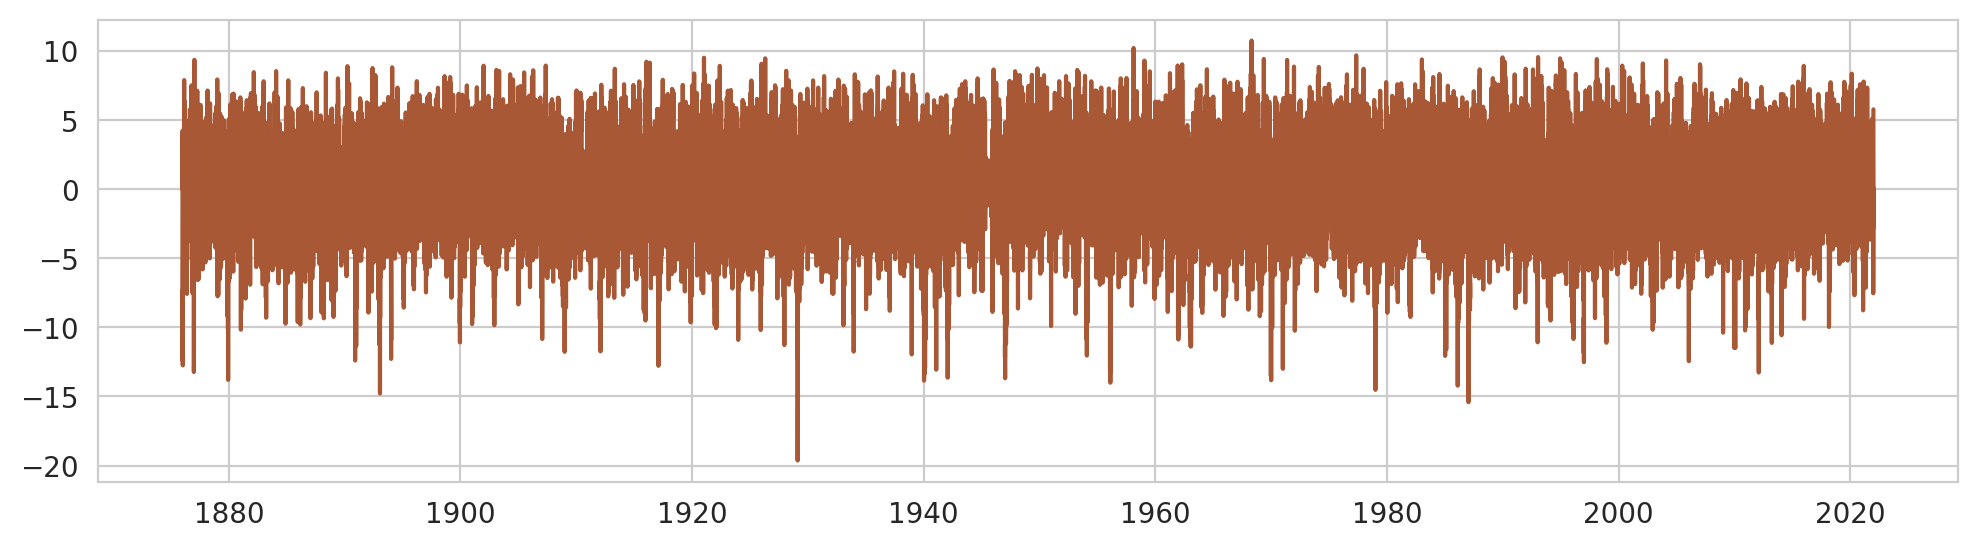

In [130]:
forecast = model_stats.predict(horizon=365)
plt.plot(forecast, c='#A85835')

## Show Training Error

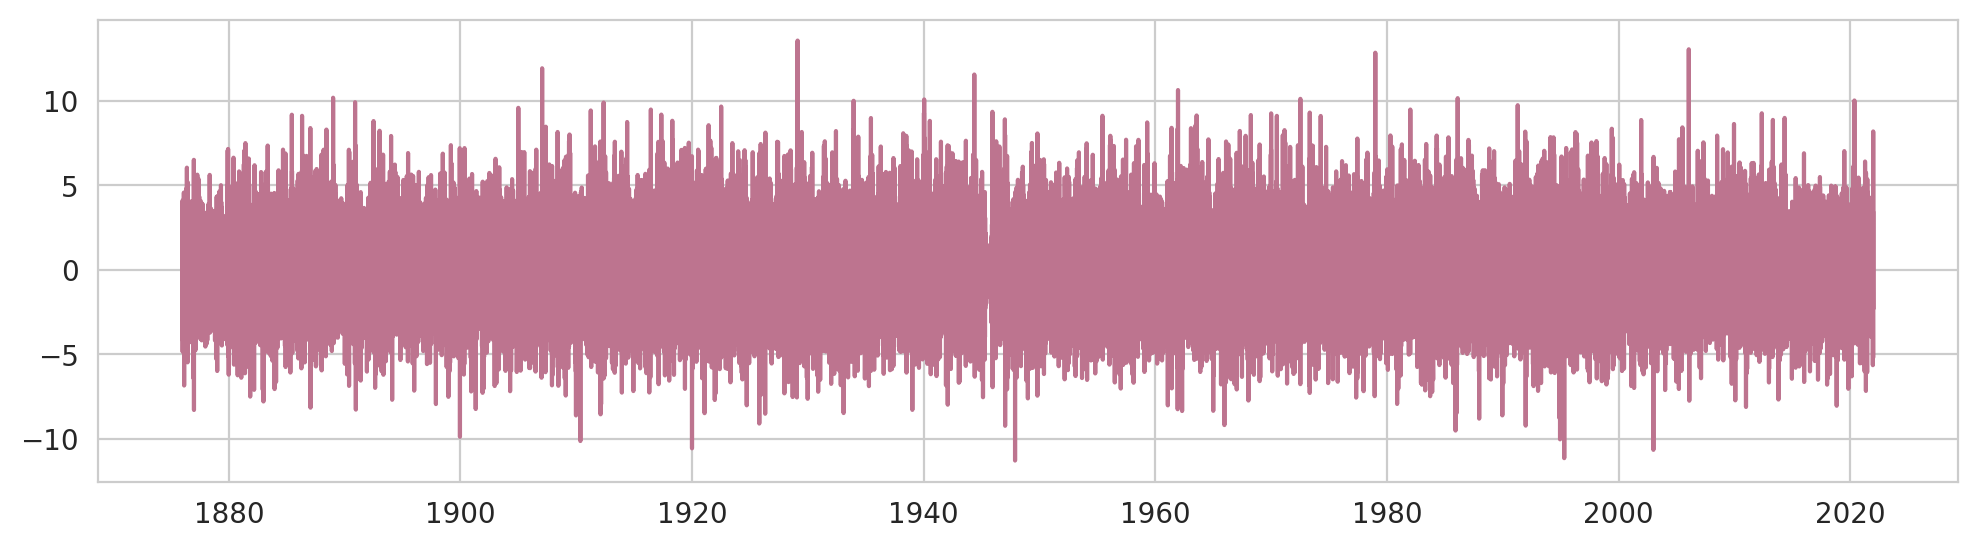

In [131]:
train_error = forecast-weather['remainder'].values

plt.plot(train_error, c='#BD748F')

## Load test data

In [122]:
weather_test = pd.read_csv('data/test.csv', sep=',', parse_dates=True)
weather_test['date'] = pd.to_datetime(weather_test['date'])
weather_test = weather_test.set_index('date')

## Make Predictions for remainder

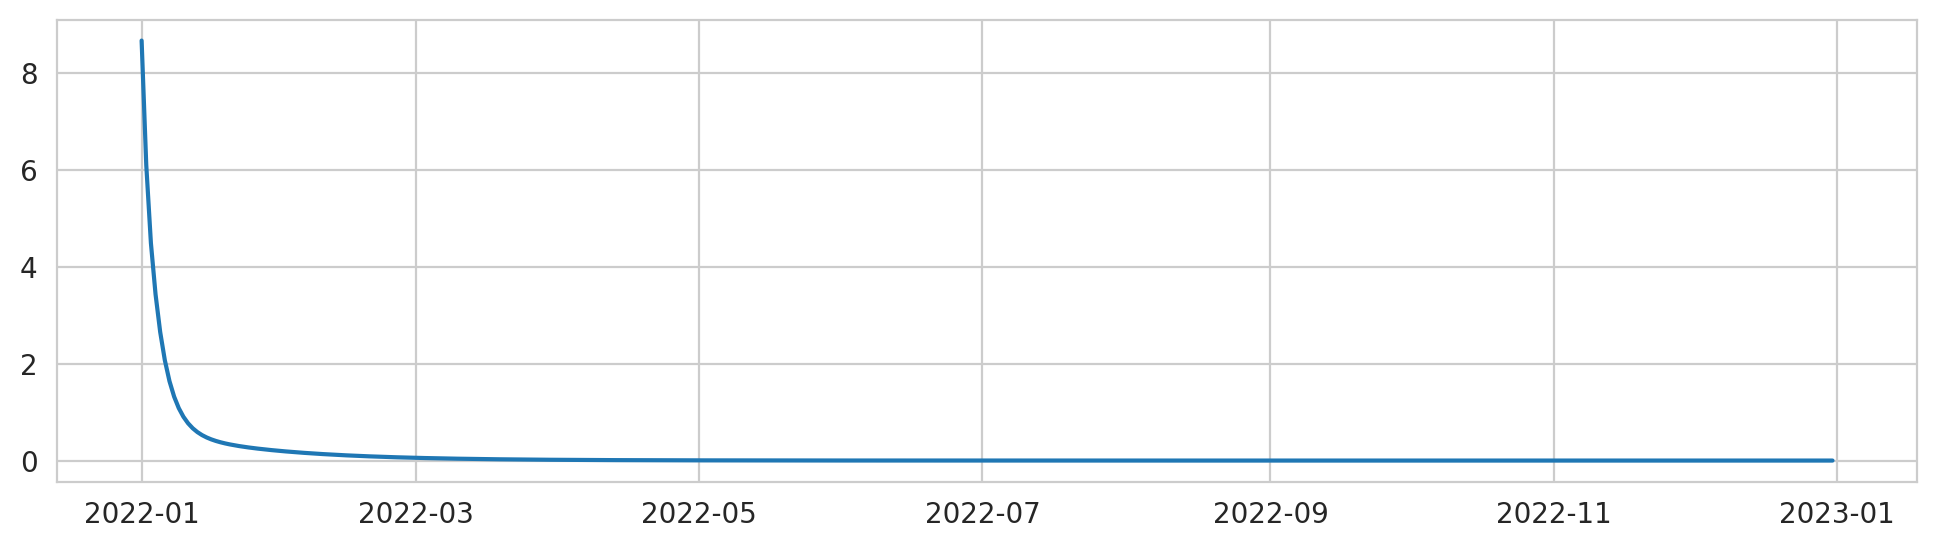

In [123]:
weather_test['forecast'] = model_stats.forecast(steps= len(weather_test))
#prediction = basic_model + forecast
plt.plot(weather_test.index, weather_test['forecast'])
#plt.plot(df_test.index, basic_model)
#plt.plot(df_test.index, df_test['temp'])

## Make Forcast Basic Model

In [124]:
weather_test['timestep_season'] = list(range(1,weather_test.shape[0]+1))
weather_test['timestep_trend'] = list(range(weather.shape[0], weather.shape[0]+weather_test.shape[0]))

weather_test

,temp,forecast,timestep_season,timestep_trend
date,,,,
2022-01-01,12.0,8.665576e+00,1,53326
2022-01-02,9.9,6.097963e+00,2,53327
2022-01-03,8.9,4.487669e+00,3,53328
2022-01-04,6.4,3.429233e+00,4,53329
2022-01-05,3.8,2.651221e+00,5,53330
...,...,...,...,...
2022-12-27,4.2,1.369347e-07,361,53686
2022-12-28,6.3,1.311764e-07,362,53687
2022-12-29,10.0,1.256602e-07,363,53688


In [125]:
weather_test['forecast_trend'] = trend_model.predict(weather_test[['timestep_trend']])
weather_test['forecast_season'] = seasonal_model.predict(weather_test[['timestep_season']])

weather_test['forecast_complete'] = weather_test['forecast_trend'] + weather_test['forecast_season']+ weather_test['forecast']

weather_test

,temp,forecast,timestep_season,timestep_trend,forecast_trend,forecast_season,forecast_complete
date,,,,,,,
2022-01-01,12.0,8.665576e+00,1,53326,11.002340,-9.292353,10.375563
2022-01-02,9.9,6.097963e+00,2,53327,11.002451,-9.044441,8.055973
2022-01-03,8.9,4.487669e+00,3,53328,11.002563,-8.906803,6.583429
2022-01-04,6.4,3.429233e+00,4,53329,11.002674,-8.997246,5.434661
2022-01-05,3.8,2.651221e+00,5,53330,11.002785,-9.193170,4.460837
...,...,...,...,...,...,...,...
2022-12-27,4.2,1.369347e-07,361,53686,11.042593,-8.807152,2.235441
2022-12-28,6.3,1.311764e-07,362,53687,11.042706,-8.653762,2.388944
2022-12-29,10.0,1.256602e-07,363,53688,11.042818,-8.788727,2.254091


<AxesSubplot:title={'center':'Long Term Weather Forcast (365 days)'}, xlabel='date'>

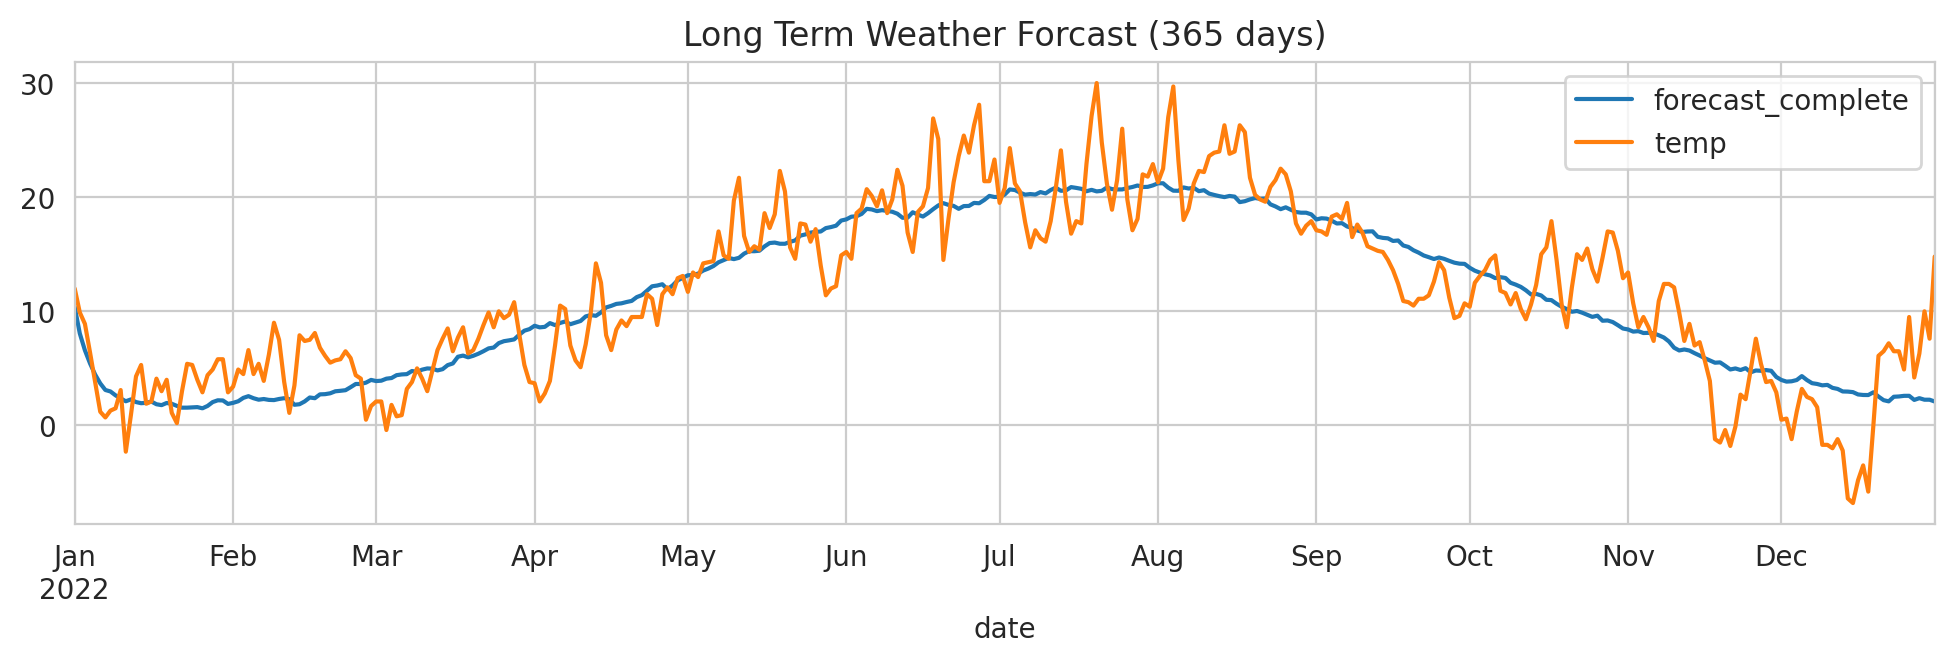

In [127]:


weather_test[['forecast_complete', 'temp']].plot(title='Long Term Weather Forcast (365 days)')